In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

import random

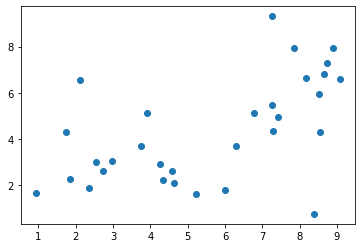

In [3]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
xkcd = pandas.read_csv(url)

plt.scatter(xkcd.x, xkcd.y)

In [4]:
xkcd.x

0     0.9293
1     1.7356
2     1.8546
3     2.1073
4     2.3637
5     2.5417
6     2.7176
7     2.9618
8     3.7442
9     3.9209
10    4.2629
11    4.3290
12    4.5732
13    4.6230
14    5.2355
15    5.9960
16    6.3058
17    6.7838
18    7.2509
19    7.2583
20    7.2865
21    7.4109
22    7.8511
23    8.1576
24    8.3872
25    8.5173
26    8.5555
27    8.6645
28    8.7260
29    8.9059
30    9.0856
Name: x, dtype: float64

In [5]:
import signal
class Interruptable():
    class Breakout(Exception):
        pass
    def __init__(self):
        self.interrupted = False
        self.orig_handler = None
    def __enter__(self):
        self.orig_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handle)
        return self.check
    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.signal(signal.SIGINT, self.orig_handler)
        if exc_type == Interruptable.Breakout:
            print(' stopped')
            return True
        return False
    def handle(self, signal, frame):
        if self.interrupted:
            self.orig_handler(signal, frame)
        print('Interrupting ...', end='')
        self.interrupted = True
    def check(self):
        if self.interrupted:
            raise Interruptable.Breakout
            
def enumerate_cycle(g, shuffle=True):
    epoch = 0
    while True:
        if shuffle:
            for i,j in enumerate(np.random.permutation(len(g))):
                yield (epoch,i), g[j]
        else:
            for i,x in enumerate(g):
                yield (epoch,i), x
        epoch = epoch + 1

# Question (a)

Define model:

In [5]:
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x):
        return self.f(x)
    
class RWiggle(nn.Module):
    """Y_i ~ N(f(x_i), sigma2)"""
    def __init__(self):
        super().__init__()
        self.mu = Wiggle()
        self.sigmapre = nn.Parameter(torch.tensor(1.0))
    @property
    def sigma(self):
         return torch.nn.functional.softplus(self.sigmapre)
    def forward(self, y, x):
        sigma2 = torch.pow(self.sigma, 2)
        return - 0.5*torch.log(2*np.pi*sigma2) - torch.pow(y - self.mu(x), 2) / (2*sigma2)

Train model:

In [6]:
x = torch.tensor(xkcd.x, dtype=torch.float)[:, None]
y = torch.tensor(xkcd.y, dtype=torch.float)[:, None]

simple_wiggle = RWiggle()
epoch = 0
optimizer = optim.Adam(simple_wiggle.parameters())
simple_training_loglik = []

with Interruptable() as check_interrupted:
    while epoch < 50000:
        check_interrupted()
        optimizer.zero_grad()
        loglikelihood = torch.mean(simple_wiggle(y, x))
        (-loglikelihood).backward()
        optimizer.step()
        epoch += 1
        if epoch % 100 == 0:
            simple_training_loglik.append(loglikelihood.item())
#         print(f'epoch=={epoch}, loglik={loglikelihood.item():.4}, sigma={simple_wiggle.sigma.item():.4}')
        

Plot the model:

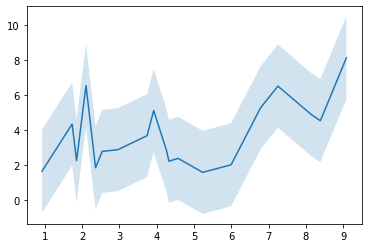

In [7]:
mu_x = simple_wiggle.mu(x).detach().numpy()
sigma = simple_wiggle.sigma.item()

plt.plot(xkcd.x, mu_x)
plt.fill_between(xkcd.x, (mu_x-1.96*sigma).reshape(31,), (mu_x+1.96*sigma).reshape(31,), alpha=0.2)

In [8]:
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x):
        return self.f(x)
    
class HeteroscedasticRWiggle(nn.Module):
    """Y_i ~ N(f(x_i), f(x_i)^2)"""
    def __init__(self):
        super().__init__()
        self.mu = Wiggle()
        self.sigmapre = Wiggle()
    def sigma(self, x):
         return torch.nn.functional.softplus(self.sigmapre(x))
        
    def forward(self, y, x):
        sigma2 = torch.pow(self.sigma(x), 2)
        return - 0.5*torch.log(2*np.pi*sigma2) - torch.pow(y - self.mu(x), 2) / (2*sigma2)

In [9]:
heteroscedastic_wiggle = HeteroscedasticRWiggle()
epoch = 0
optimizer = optim.Adam(heteroscedastic_wiggle.parameters())
heteroscedastic_training_likelihood = []

with Interruptable() as check_interrupted:
    while epoch < 50000:
        check_interrupted()
        optimizer.zero_grad()
        loglikelihood = torch.mean(heteroscedastic_wiggle(y, x))
        (-loglikelihood).backward()
        optimizer.step()
        epoch += 1
        if epoch % 100 == 0:
            heteroscedastic_training_likelihood.append(loglikelihood.item())
#             print(f'epoch=={epoch}, loglik={loglikelihood.item():.4}')
            
#             print(f'sigma={heteroscedastic_wiggle.sigma(x)}')

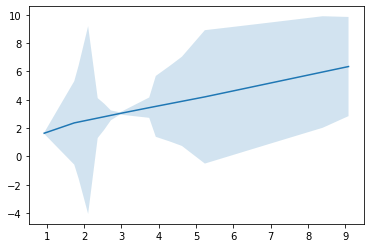

In [10]:
mu_x = heteroscedastic_wiggle.mu(x).detach().numpy()
sigma = heteroscedastic_wiggle.sigma(x).detach().numpy()

plt.plot(xkcd.x, mu_x)
plt.fill_between(xkcd.x, (mu_x-1.96*sigma).reshape(31,), (mu_x+1.96*sigma).reshape(31,), alpha=0.2)

# Question (b)

Maximum possible training log likelihood for *each* of these two models?
- Is this related to the perfect sampling distribution under importance sampling?

If it's useful, we can calculate the log likelihood for the data under a perfectly overfitted model. To do so we use the empirical distribution, $$q_x =  \frac{\text{# of occurrences of x}}{\text{total number of samples}} $$

In [ ]:
def q(x):
    _, counts = np.unique(x, return_counts=True)
    return counts/x.shape[0]

In [ ]:
q_res = q(x)

np.sum(q_res * np.log(q_res))

-3.4339872044851463

Plot a graph of the training likelihood as a function of epoch, for both models:

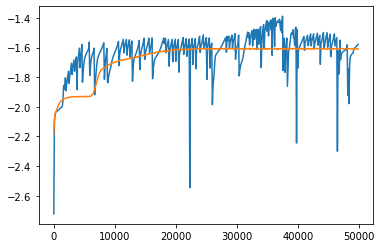

In [12]:
epochs = np.arange(1, 50000, 100)

plt.plot(epochs, heteroscedastic_training_likelihood)
plt.plot(epochs, simple_training_loglik)

**Investigation**
The dips occur when the optimisation algorithm tries large values for parameter $\sigma$. For example, a dip occurs from log likelihood -1.046 to -1.539. The mean of the $\sigma(x)$ vectors for those likelihoods are 1.1963 and 1.5876 - $\sigma$ is just larger when the dip occurs.

But why? Why does it happen when sigma depends on x, but not before? The mean would be the same.

# Question (c)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting pytorch-data/MNIST/raw/train-images-idx3-ubyte.gz to pytorch-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting pytorch-data/MNIST/raw/train-labels-idx1-ubyte.gz to pytorch-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting pytorch-data/MNIST/raw/t10k-images-idx3-ubyte.gz to pytorch-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting pytorch-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to pytorch-data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


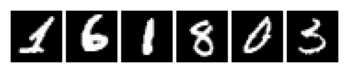

In [3]:
import torchvision

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',  # where to put the files
    download = True,         # if files aren't here, download them
    train = True,            # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)


# Images can be plotted with matplotlib imshow
import torch
import matplotlib.pyplot as plt
show = [mnist[i] for i in [59289, 28001, 35508, 43876, 23627, 14028]]
show = torch.stack([img for img,lbl in show])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=100)

In [4]:
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))


class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ+σ*ε)
        return ll - kl

In [14]:
autoencoder = GaussianEncoder(BernoulliImageGenerator())
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 100:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(autoencoder.loglik_lb(images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")

epoch: 1, loglikelihood: -147.0
epoch: 2, loglikelihood: -87.89
epoch: 3, loglikelihood: -70.8
epoch: 4, loglikelihood: -61.69
epoch: 5, loglikelihood: -58.14
epoch: 6, loglikelihood: -56.67
epoch: 7, loglikelihood: -56.47
epoch: 8, loglikelihood: -55.79
epoch: 9, loglikelihood: -55.74
epoch: 10, loglikelihood: -55.1
epoch: 11, loglikelihood: -54.89
epoch: 12, loglikelihood: -54.55
epoch: 13, loglikelihood: -54.65
epoch: 14, loglikelihood: -54.06
epoch: 15, loglikelihood: -53.89
epoch: 16, loglikelihood: -54.36
epoch: 17, loglikelihood: -53.9
epoch: 18, loglikelihood: -53.1
epoch: 19, loglikelihood: -53.05
epoch: 20, loglikelihood: -52.95
epoch: 21, loglikelihood: -53.19
epoch: 22, loglikelihood: -52.55
epoch: 23, loglikelihood: -52.7
epoch: 24, loglikelihood: -52.3
epoch: 25, loglikelihood: -53.43
epoch: 26, loglikelihood: -52.49
epoch: 27, loglikelihood: -51.88
epoch: 28, loglikelihood: -51.36
epoch: 29, loglikelihood: -51.29
epoch: 30, loglikelihood: -52.11
epoch: 31, loglikelihood:

In [15]:
torch.save(autoencoder.state_dict(), '4-dim-100-epoch.pt')

In [17]:
torch.save(autoencoder.state_dict(), 'autoencoder.pt')

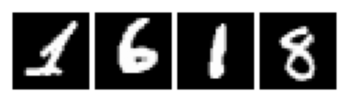

torch.Size([4, 1, 28, 28])

In [44]:
show_res = [mnist[i] for i in [59289, 28001, 35508, 43876]]
show_res = torch.stack([img for img,lbl in show_res])
x_res = torchvision.utils.make_grid(show_res, nrow=6, pad_value=1)
plt.imshow(x_res.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

show_res.shape

## Images + reconstructions

<function matplotlib.pyplot.show>

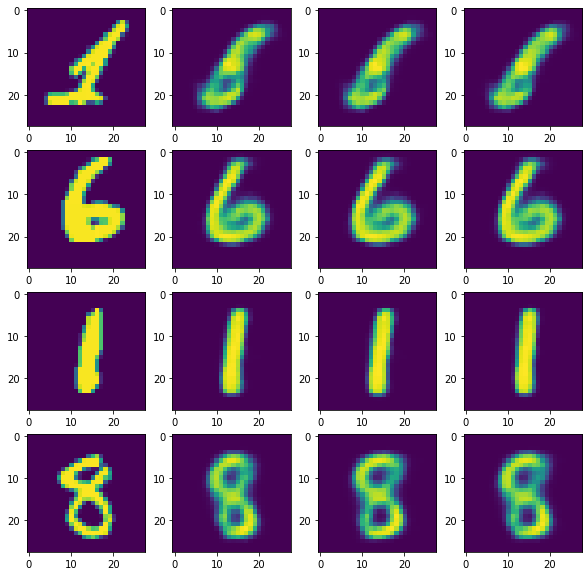

In [53]:
new_images = []
for image in show_res:
  image = image.reshape((1, 1, 28, 28))
  new_images.append(image.detach().numpy()[0][0])
  for i in range(3):
    mu, sigma = autoencoder(image)
    epsilon = torch.randn_like(sigma)
    z = mu + sigma*epsilon
    new_image = autoencoder.f(z)
    new_images.append(new_image.detach().numpy()[0][0])

cols, rows = 4, 4
fig = plt.figure(figsize=(10, 10))

for i in range(1, cols*rows + 1):
  fig.add_subplot(rows, cols, i)
  plt.imshow(new_images[i-1])
plt.show

## Varying noise for 35508

<function matplotlib.pyplot.show>

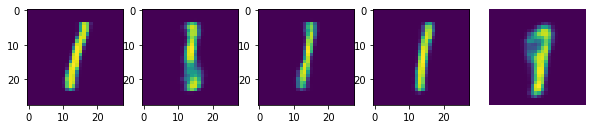

In [11]:
image, _ = mnist[35508]
image = image.reshape((1, 1, 28, 28))
mu, sigma = autoencoder(image)

z = [mu + torch.randn_like(sigma) for _ in range(5)]
new_images = [autoencoder.f(z_i) for z_i in z]
fig = plt.figure(figsize=(10, 10))

for i in range(len(new_images)):
  fig.add_subplot(1, 5, i+1)
  plt.imshow(new_images[i].detach().numpy()[0][0])
plt.axis('off')
plt.show

## 12 random images

How to generate 12 random images? What gets fed into the encoder?

In [ ]:
# Generating 12 different latent variables which we can use to sample new data.
# We generate these from 12 data-points chosen at random from the dataset.

mu, sigma = autoencoder(images)
z = mu + sigma*torch.randn_like(sigma)

# Do this 12 times? Or does it need to see different data?
autoencoder.f(z)

In [16]:
images = [] # A list of tensors representing each image. The shape of each tensor is 1x28x28.
for image, _ in mnist:
  images.append(image)

torch.Size([1, 28, 28])

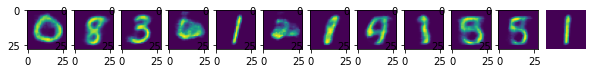

In [29]:
# Pick 12 images at random.
random_subset = [images[random.randrange(0, len(images))] for _ in range(12)]
corresponding_latent_vars = [autoencoder(image.reshape((1, 1, 28, 28))) for image in random_subset]
generated_images = [autoencoder.f(mu_i + sigma_i * torch.randn_like(sigma_i)) for (mu_i, sigma_i) in corresponding_latent_vars]

fig = plt.figure(figsize=(10, 10))

for i in range(len(new_images)):
  fig.add_subplot(1, 12, i+1)
  plt.imshow(generated_images[i].detach().numpy()[0][0])
plt.axis('off')
plt.show()

## Interpolating two images

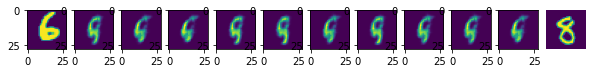

In [26]:
(img1, _), (img2, _) = mnist[28001], mnist[43876]
img1 = img1.reshape((1, 1, 28, 28))
img2 = img2.reshape((1, 1, 28, 28))
mu1, sigma1 = autoencoder(img1)
mu2, sigma2 = autoencoder(img2)
z1 = mu1 + torch.randn_like(sigma1)
z2 = mu2 + torch.randn_like(sigma2)

interpolated_vars = []
for _ in range(10):
  coef = random.random()
  interpolated_vars.append(z1 + coef*(z2-z1))

new_images = [img1]
for z_i in interpolated_vars:
  new_images.append(autoencoder.f(z_i))
new_images.append(img2)

fig = plt.figure(figsize=(10, 10))


for i in range(len(new_images)):
  fig.add_subplot(1, 12, i+1)
  plt.imshow(new_images[i].detach().numpy()[0][0])
plt.axis('off')
plt.show()

---

# Question (d)

1. Modify autoencoder so it uses 100 samples for MCI. 
  - Changed the behaviour inside `loglik_lb` so that it generates `n_samples` for each $Z_i$, where previously it was generating just one and computing the likelihood of the data given that one sample.
2. Show likely/unlikely images. What makes an image likely?
  - It looks like unlikely images do not look like digits at all - they're just blobs. They have some sort of structure, but it seems arbitrary. 
  - Likely images are simpler digits, like 1 (a vertical bar) or 7 (a vertical bar and a horizontal bar at the top).

In [71]:
class BernoulliImageGeneratorExpandedSampling(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
      """ When this is called, the argument z is the value that a random variable Z takes on.
          It's a bit confusing, because z is actually a vector of z_i that random variables Z_i take on.
          This equates to the likelihood of each x_i under a particular choice of z - one sample. To do
          multiple samples, we need to try multiple values of little z, which happens when this is called."""
      xr = self(z)
      return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1, 2, 3))


class GaussianEncoderExpandedSampling(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )
        self.max_likelihood = (0, 0)
        self.min_likelihood = (0, 0)

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, batch_num, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)

        # Running the below is equivalent to sampling just once
        # a value for Z(phi, x) for each of the data poitns in the
        # vector x. If we want multiple samples, we don't need to
        # pass through the encoder again - that will be the same,
        # given the parameters we have now. But if we sample the
        # noise epsilon again, we'll get a different Z(phi, x).
        ll = 0
        num_samples = 1
        for _ in range(num_samples):
          ε = torch.randn_like(σ)
          ll += self.f.loglik(x, z=μ+σ*ε)
        ll /= num_samples

        if torch.min(ll) < self.min_likelihood[0]:
          self.min_likelihood = torch.min(ll), torch.argmin(ll) + batch_num*100

        if torch.max(ll) < self.max_likelihood[0]:
          self.max_likelihood = torch.max(ll), torch.argmax(ll) + batch_num*100

        # Sum up all likelihoods to find likelihood of dataset.
        return ll - kl

In [86]:
autoencoder_expanded_sampling = GaussianEncoderExpandedSampling(BernoulliImageGeneratorExpandedSampling())
optimizer = optim.Adam(autoencoder_expanded_sampling.parameters())
epoch = 0

while epoch < 10:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(autoencoder_expanded_sampling.loglik_lb(batch_num, images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")

epoch: 1, loglikelihood: -150.7
epoch: 2, loglikelihood: -141.1
epoch: 3, loglikelihood: -134.9
epoch: 4, loglikelihood: -133.0
epoch: 5, loglikelihood: -131.6
epoch: 6, loglikelihood: -129.5
epoch: 7, loglikelihood: -127.4
epoch: 8, loglikelihood: -126.5
epoch: 9, loglikelihood: -125.1
epoch: 10, loglikelihood: -125.6


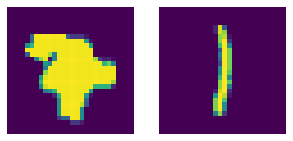

In [85]:
likely, _ = mnist[72]
unlikely, _ = mnist[1618]

fig = plt.figure(figsize=(5, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(unlikely[0])
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(likely[0])
plt.axis('off')

plt.show()

# Question (e)

Train the autoencoder with 20 dimensions:

In [10]:
autoencoder = GaussianEncoder(BernoulliImageGenerator(20))
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 10:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(autoencoder.loglik_lb(images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")

torch.save(autoencoder.state_dict(), '20-dim-10-epoch.pt')

epoch: 1, loglikelihood: -156.5
epoch: 2, loglikelihood: -100.2
epoch: 3, loglikelihood: -73.05
epoch: 4, loglikelihood: -70.77
epoch: 5, loglikelihood: -65.88
epoch: 6, loglikelihood: -64.52
epoch: 7, loglikelihood: -63.34
epoch: 8, loglikelihood: -63.42
epoch: 9, loglikelihood: -60.44
epoch: 10, loglikelihood: -59.27


In [11]:
torch.save(autoencoder.state_dict(), '20-dim-10-epoch.pt')

Evaluate "them" - the dimensions? Explain your grounds for comparison.

Focus on evaluation metrics.

9


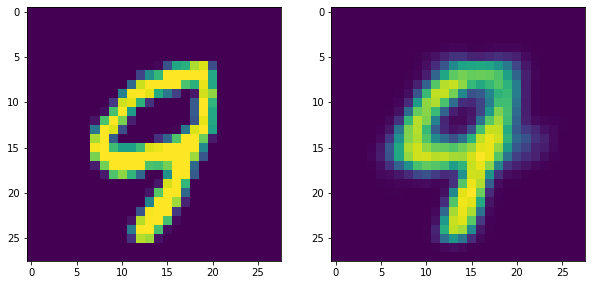

In [101]:
img, label = mnist[42069]
img = img.reshape((1, 1, 28, 28))
mu, sig = autoencoder_expanded_sampling(img)
eps = torch.randn_like(sig)
z = mu + sig*eps

reconstr_x = autoencoder_expanded_sampling.f(z)

print(label)
fig = plt.figure(figsize=(10, 10))


fig.add_subplot(1, 2, 1)
plt.imshow(img[0][0])

fig.add_subplot(1, 2, 2)
plt.imshow(reconstr_x.detach().numpy()[0][0])

plt.show()

# Question (f)

1. Train a generative model $X = f(Z, y)$ so that $Z$ captures the style of the digit. 
2. Show 4 sets of styles with different digits in each style.

In [6]:
ones = [(image, label) for image, label in mnist if label==1]
mnist_batched = torch.utils.data.DataLoader(ones, batch_size=100)

In [8]:
autoencoder = GaussianEncoder(BernoulliImageGenerator(4))
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 100:
    for batch_num, (images, labels) in enumerate(mnist_batched):
        optimizer.zero_grad()
        loglik_lb = torch.mean(autoencoder.loglik_lb(images))
        (-loglik_lb).backward()
        optimizer.step()
    epoch += 1
    print(f"epoch: {epoch}, loglikelihood: {loglik_lb.item():.4}")

torch.save(autoencoder.state_dict(), 'ones.pt')

epoch: 1, loglikelihood: -134.2
epoch: 2, loglikelihood: -95.26
epoch: 3, loglikelihood: -80.74
epoch: 4, loglikelihood: -72.33
epoch: 5, loglikelihood: -64.75
epoch: 6, loglikelihood: -60.26
epoch: 7, loglikelihood: -59.56
epoch: 8, loglikelihood: -57.37
epoch: 9, loglikelihood: -56.31
epoch: 10, loglikelihood: -56.11
epoch: 11, loglikelihood: -56.08
epoch: 12, loglikelihood: -55.37
epoch: 13, loglikelihood: -56.04
epoch: 14, loglikelihood: -55.1
epoch: 15, loglikelihood: -54.92
epoch: 16, loglikelihood: -54.61
epoch: 17, loglikelihood: -54.72
epoch: 18, loglikelihood: -55.26
epoch: 19, loglikelihood: -54.04
epoch: 20, loglikelihood: -54.56
epoch: 21, loglikelihood: -53.82
epoch: 22, loglikelihood: -53.36
epoch: 23, loglikelihood: -54.01
epoch: 24, loglikelihood: -53.87
epoch: 25, loglikelihood: -53.49
epoch: 26, loglikelihood: -53.48
epoch: 27, loglikelihood: -53.13
epoch: 28, loglikelihood: -53.04
epoch: 29, loglikelihood: -52.77
epoch: 30, loglikelihood: -52.64
epoch: 31, loglikeli

In [43]:
torch.save(autoencoder.state_dict(), 'ones.pt')

In [5]:
# Reload ones model.
autoencoder = GaussianEncoder(BernoulliImageGenerator(4))
autoencoder.load_state_dict(torch.load('ones.pt'))

FileNotFoundError: ignored

In [1]:
random_image, random_label = ones[random.randrange(0, len(ones)-1)]
mu, sigma = autoencoder(random_image.reshape((1, 1, 28, 28)))

epsilon = [torch.randn_like(sigma) for _ in range(1, 11)]

reconstructed_images = [autoencoder.f(mu + sigma*ep) for ep in epsilon]

fig = plt.figure(figsize=(10, 10))

for i in range(1, len(reconstructed_images)):
  if i <= 5:
    fig.add_subplot(1, 5, i)
  else:
    fig.add_subplot(2, 5, i)

  plt.imshow(reconstructed_images[i-1].detach().numpy()[0][0])

NameError: ignored